In [7]:
import numpy as np
import pandas as pd
import sklearn


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

from dataproc import load_animes, load_profiles_reviews
from tqdm import tqdm

Data may be downloaded from here

https://www.kaggle.com/marlesson/myanimelist-dataset-animes-profiles-reviews/version/1?select=profiles.csv

In [8]:
sklearn.__version__

'1.0'

In [13]:
anime_path = 'animes.csv'
profiles_path = 'profiles.csv'
reviews_path = 'reviews.csv'

In [32]:
anime = load_animes(anime_path)
reviews, profiles = load_profiles_reviews(reviews_path, profiles_path)

# PURE CONTENT BASED MODELS

We will explore application of regression and classification approaches.

In regression task (in its straightforward implementation) we want to predict average score based on any parameter (parameters) of anime. Here we will use TFIDF vectors of synopsis of each anime

$$
S = W * x +W_0
$$

where $x$ - tfidf vectors $S$ -predicted scores, $W_0$ -bias

We have TfIdf vectores and average scores to pursue this task

In [34]:
def get_scores(anime):
    '''
    Cleanup/preprocess scores values.
    '''
    scored_df = (
        anime[['anime_id', 'score', 'soup']]
        .query('score > 0')
    )
    return scored_df

anime_scores = get_scores(anime)
anime_scores.head(3)

,anime_id,score,soup
0,28891,8.82,following participation inter high karasuno hi...
1,23273,8.83,music accompanies path human metronome prodigi...
2,34599,8.83,abyss gaping chasm stretching depths earth fil...


In [35]:
def get_test_pairs(profiles, reviews, n_pairs, score_cutoff=5, seed=0):
    '''
    we define test pairs - 
    users with n animes the like 
    and the same amount of animes they dislike
    '''
    rs = np.random.RandomState(0)
    user_favorites = (
        profiles
        .set_index('profile_idx')['favorites_anime']
        .apply(lambda x: rs.choice(x, n_pairs, replace=False) if len(x)>=n_pairs else [])
        .loc[lambda x: x.apply(len) > 0]
        .rename('likes')
    )
    user_negatives = (
        reviews
        .query('score < @score_cutoff and profile_idx in @user_favorites.index')
        .groupby('profile_idx')['anime_id']
        .apply(list)
        .apply(lambda x: rs.choice(x, n_pairs, replace=False) if len(x)>=n_pairs else [])
        .loc[lambda x: x.apply(len) > 0]
        .rename('dislikes')
    )
    test_pairs = pd.concat([user_favorites, user_negatives], axis=1, join='inner')
    return test_pairs

In [73]:
def create_anime_train_(anime, test_pairs):
    '''
    delete test animes from anime dataset
    '''
    labels_to_drop = []
    anime_scores = get_scores(anime)
    for user_id in test_pairs.index:
        labels_to_drop.extend(test_pairs.loc[user_id].likes)
        labels_to_drop.extend(test_pairs.loc[user_id].dislikes)
    labels_to_drop = set(labels_to_drop)
    anime_= anime_scores.query('anime_id not in @labels_to_drop')
    return anime_

In [270]:
test_pairs = get_test_pairs(profiles, reviews, 2)
anime_ = create_anime_train_(anime, test_pairs)

# Regression Task

In [116]:
def build_cb_model(config, trainset, trainset_description):
    # create TfIDF matrix
    word_vectorizer = TfidfVectorizer(**config['tfidf'])
    tfidf_matrix = word_vectorizer.fit_transform(trainset[trainset_description['item_features']])
    # fit model
    reg = LinearRegression().fit(tfidf_matrix, trainset[trainset_description["feedback"]].values)
    return reg, word_vectorizer


def cb_model_scoring(params, testset, testset_description):
    '''
    predict the scores for our data
    '''
    reg, word_vectorizer = params
    tf_idf_matrix = word_vectorizer.transform(testset[testset_description['item_features']])
    scores = reg.predict(tf_idf_matrix)
    return scores

In [117]:
# we define configuration of our model
# basically, a set of hyper-parameters
cb_config = {
    "tfidf": dict( # TfIDF Vectorizer config
        ngram_range = (1, 1),
        min_df=5, max_df=0.9,
        strip_accents='unicode',
        stop_words = 'english',
        analyzer = 'word',
        use_idf=1,
        smooth_idf=1,
        sublinear_tf=1
    ),
}
# we also define a general representation of our dataset
anime_description = {
    "items": "anime_id",
    "item_features": "soup",
}

In [118]:
anime_description['feedback'] = 'score'
cb_params = build_cb_model(cb_config, anime_, anime_description)

In [119]:
cb_scores = cb_model_scoring(cb_params, anime_, anime_description)

# Analyzing features 

In [204]:
def top_idx(a, topk):
    parted = np.argpartition(a, -topk)[-topk:]
    return parted[np.argsort(-a[parted])]

In [123]:
def significant_features(params, topn=10, reverse=False):
    '''
    print the most or the least if reverse is true 
    significant features for a model with abs of its weghts
    '''
    reg, word_vectorizer = params
    features_weights = reg.coef_.squeeze()
    if reverse:
        features_weights = -features_weights
    top_features_idx = top_idx(features_weights, topn)
    features = word_vectorizer.get_feature_names_out()
    feature_scores = pd.DataFrame(
        zip(features[top_features_idx], features_weights[top_features_idx]),
        columns = ['feature', 'abs(weight)']
    )
    return feature_scores

In [126]:
significant_features(cb_params)

,feature,abs(weight)
0,kensetsu,23.553075
1,rantarou,21.151100
2,fi,15.290137
3,multitude,14.994913
4,lamperouge,14.940619
5,arduous,12.937629
6,prompting,12.921582
7,swore,12.723055
8,challenger,12.602501
9,reigning,12.355513


In [127]:
significant_features(cb_params, reverse=True)

,feature,abs(weight)
0,nintama,20.844622
1,sci,15.033451
2,latent,13.539301
3,kururugi,11.361679
4,tackle,11.249427
5,coffy,10.960947
6,taisei,10.717617
7,cliffs,10.569892
8,abundant,10.487510
9,firsthand,10.434869


## Simple evaluation

In [128]:
np.sqrt(np.mean((anime_['score'].values - cb_scores)**2))

0.3176052887507751

In [129]:
np.mean(np.abs(anime_['score'].values - cb_scores))

0.23503513141572813

<AxesSubplot:>

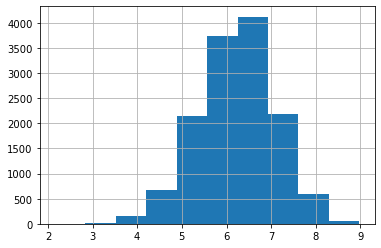

In [130]:
pd.Series(cb_scores).hist()

## A little more difficult evaluation

In [131]:
test_pairs

,likes,dislikes
profile_idx,,
45780,"[2136, 11827]","[3402, 2944]"
46058,"[5959, 12957]","[24327, 21925]"
35541,"[269, 2798]","[3980, 3793]"
46519,"[437, 1454]","[4934, 5813]"
29983,"[933, 26055]","[5569, 33820]"
...,...,...
14698,"[9756, 17074]","[33003, 34966]"
6929,"[14719, 11111]","[32979, 36266]"
15720,"[2025, 339]","[34966, 3287]"


In [144]:
def create_test_soup(test_pairs, anime):

    '''
    Pick out all the text info (soup) for every anime from test_pairs
    '''
    
    ind = 0
    id_2_n = dict()
    n_2_id = dict()
    soups = []
    for like in test_pairs.likes:

        id_2_n[like] = ind
        n_2_id[ind] = like
        
        ind += 1
        line = ""
        if len(anime.soup[anime.anime_id == like].values) > 0:
            line += anime.soup[anime.anime_id == like].values[0]
        soups.append(line)
        
    for dislike in test_pairs.dislikes:

        id_2_n[dislike] = ind
        n_2_id[ind] = dislike
        
        ind += 1
        line = ""
        if len(anime.soup[anime.anime_id == dislike].values) > 0:
            line += anime.soup[anime.anime_id == dislike].values[0]
        soups.append(line)
    return id_2_n, n_2_id, soups

In [145]:
profiles

,profile,gender,birthday,favorites_anime,link,profile_idx
31951,sdrowkcab,NaN,NaN,[],https://myanimelist.net/profile/sdrowkcab,44000
31952,INU4SH4,Male,"Nov 22, 1996","[19, 457, 634, 26, 437, 11341, 455, 34537, 225...",https://myanimelist.net/profile/INU4SH4,11445
31953,thetickdickler,NaN,NaN,"[221, 3350, 11827, 4714, 2681, 2136, 1405, 368...",https://myanimelist.net/profile/thetickdickler,45780
31954,Sidewinder51,NaN,NaN,[],https://myanimelist.net/profile/Sidewinder51,24591
31955,trashonthecurb,Female,NaN,"[23033, 2798, 5959, 12957, 17745]",https://myanimelist.net/profile/trashonthecurb,46058
...,...,...,...,...,...,...
81722,lovelessxd,Female,"Aug 6, 1992","[853, 5114]",https://myanimelist.net/profile/lovelessxd,39702
81723,Shattered_Angel,Female,"Sep 6, 1994","[150, 27, 1520, 121, 31452, 32995, 877, 14713,...",https://myanimelist.net/profile/Shattered_Angel,24199
81724,FluffyWalrus,Male,NaN,"[121, 43, 237, 202, 205]",https://myanimelist.net/profile/FluffyWalrus,9035
81725,camco,Female,Sep 23,"[199, 4224, 7054, 13601, 14713]",https://myanimelist.net/profile/camco,33210


In [155]:
test_pairs.iloc[0].likes

array([ 2136, 11827])

In [268]:
def cb_model_evaluation(params, test_pairs, anime_test, anime_description, reviews, LOGREG=False):
    
    '''
    evaluate our model for test pairs by comparing predicted score to the ground truth
    '''

    reg, word_vectorizer = params
    
    
    n = len(test_pairs.iloc[0].likes)
    m = len(test_pairs)

    numerator  = 0
    for user_id in test_pairs.index:
        s = 0
        id_2_n, n_2_id, soups = create_test_soup(test_pairs.loc[user_id], anime)
        tf_idf_matrix = word_vectorizer.transform(soups)

        scores_predicted = np.array(reg.predict(tf_idf_matrix))
        scores_predicted = np.where(scores_predicted>10, 0, scores_predicted)
        
        l_scores = reviews[(reviews.anime_id.isin(test_pairs.loc[user_id].dislikes)) &(reviews.profile_idx == user_id)].score.values
        h_scores = []
        
        for j in range(n):
            cand = reviews[(reviews.anime_id == test_pairs.loc[user_id].likes[j]) &(reviews.profile_idx == user_id)].score.values
            
            if len(cand) > 0:
                h_scores.append(cand[0])
            else:
                h_scores.append(10)

        pros = scores_predicted[:n]
        cons = scores_predicted[n:]

        s += np.sum(np.abs(h_scores-pros) < np.abs(cons - h_scores))
        s += np.sum(np.abs(l_scores -pros) > np.abs(l_scores -cons))
        

        numerator +=s

    return numerator / (2* m*n)
        

In [174]:
reviews

,uid,profile,anime_id,text,score,scores,link,profile_idx
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938,6837
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117,32404
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664,44549
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254,35005
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149,31031
...,...,...,...,...,...,...,...,...
182629,146535,iHitokage,2593,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=146535,37018
182631,13126,Onegai,2593,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '6', 'Animation': '9...",https://myanimelist.net/reviews.php?id=13126,19916
182633,127899,Murasa22,2593,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '9', 'Animation': '...",https://myanimelist.net/reviews.php?id=127899,18362
182636,286852,srry4apologizng,2593,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '5', 'Animation': '1...",https://myanimelist.net/reviews.php?id=286852,44943


In [269]:
cb_model_evaluation(cb_params, test_pairs, anime_, anime_description, reviews)

0.5304324612920448

# Classification Task

- Your task is to turn regression model into classification model.
- Use `LogisitcRegression` class from `sklearn` fro this.
- adopt previously derived functions for the new approach.

- try using more than 2 classes (i.e., not just binary)

In classification task we predict any category (label). Here we will predict whether the  anime can be recommended or not. We will do it in simple way. For example LogReg


$$
y_{pred} = \frac{1}{1+e^{W*x +W_0}}
$$

But first of all we need to label our dataset. Let's take a look at the scores

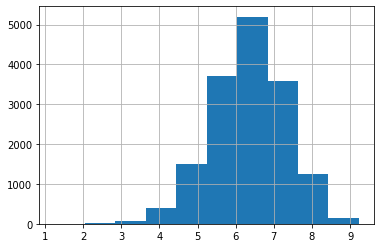

In [23]:
anime.score.hist()

The histogram shows that the mean of our average score distribution is a little bit disolased.
So we can take its mean as a borderline and say, that all the animes with average score < 6.37 are lame,  and all the animes with scores above this value are lit

In [24]:
anime.score.mean()

6.3464661417323125

In [25]:
def get_labels(anime):
    labeled_df = anime.assign(
        recommend = lambda x: x["score"].apply(...)
    )
    return labeled_df

In [27]:
anime_cl = get_labels(anime_)


In [28]:
def build_cb_log_model(config, trainset, trainset_description):
    # create TfIDF matrix
    ...
    return reg, word_vectorizer

In [29]:
cb_log_config = {**cb_config,   **{"model_config": dict(class_weight="balanced")} } 
anime_description['feedback'] = 'recommend' # 0/1 instead of scores

cb_log_params = build_cb_log_model(cb_log_config, anime_cl, anime_description)

# Analyzing features 

In [30]:
significant_features(cb_log_params)

,feature,weight
0,shounen,3.816369
1,written,3.727415
2,drama,3.616983
3,rewrite,3.543186
4,mal,3.230304
5,mystery,3.008835
6,romance,2.930423
7,idolish,2.840110
8,educational,2.776427
9,school,2.722502


In [31]:
significant_features(cb_log_params, reverse=True)

,feature,weight
0,dementia,3.984027
1,korean,3.315499
2,anidb,3.101767
3,commercial,2.670886
4,music,2.390315
5,kids,2.294752
6,short,2.280889
7,horror,2.276705
8,peeping,2.136995
9,song,1.958018


In [36]:
cb_log_scores = cb_model_scoring(cb_log_params, anime_cl, anime_description)

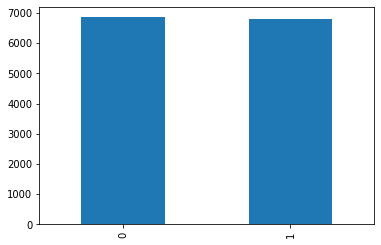

In [39]:
pd.Series(cb_log_scores).value_counts().plot.bar();


In [41]:
accuracy_score(anime_cl.recommend.values, cb_log_scores)

0.8329427274058884

In [42]:
def cb_model_evaluation_cl(params, test_pairs, anime_test, anime_description, reviews):

    '''
    evaluate our model for test pairs by comparing the probability of the correct label to 1
    '''

    reg, word_vectorizer = params
    
    
    n = len(test_pairs.iloc[0].likes)
    m = len(test_pairs)

    numerator  = 0
    for user_id in test_pairs.index:
        s = 0
        id_2_n, n_2_id, soups = create_test_soup(test_pairs.loc[user_id], anime)
        tf_idf_matrix = word_vectorizer.transform(soups)
        
        scores_predicted = reg.predict_proba(tf_idf_matrix)[:,1]

        ...
        

        numerator +=s

    return numerator / ...
        

In [45]:
cb_model_evaluation_cl(cb_log_params, test_pairs, anime_, anime_description, reviews)

0.5971703150026695

# MODEL BASED ON COSINE SIMILARITY

In [317]:
def get_interactions(anime):
    '''
    This function helps to get interconnection between index_of_soup <-> anime_id <-> soup.
    It will be useful in tfIdf
    '''
    interactions_full_df = anime[['anime_id', 'soup']]
    interactions_full_df = interactions_full_df.reset_index(drop=True)
    return interactions_full_df

def get_user_preferences(user_id, reviews, profiles):
    '''
    This function will help us to get all the animes users saw and the scores they given to each anime.
    If the anime in the users favourites bt not scored by this user, we automatically assign this anime a 10/10
    '''
    user_fav_anime_dict = {'profile_idx' : [],
                          'anime_id' : [],
                          'score' : []}
    anime_user_scored = reviews[reviews.profile_idx == user_id].anime_id.values
    user_favorites_anime = profiles[profiles.profile_idx == user_id].favorites_anime.values[0]

    for anime in user_favorites_anime:
        user_fav_anime_dict['profile_idx'].append(user_id)
        user_fav_anime_dict['anime_id'].append(anime)
        if anime not in anime_user_scored:
            user_fav_anime_dict['score'].append(10)
        else:
            user_fav_anime_dict['score'].append(reviews.loc[((reviews.profile_idx==user_id) & (reviews.anime_id==anime)), 'score'].iloc[0])


    user_fav_anime_table = pd.DataFrame.from_dict(user_fav_anime_dict)
    
    return user_fav_anime_table[['profile_idx','anime_id', 'score']]


anime_scores = get_scores(anime)
interactions_full_df = get_interactions(anime_scores)
interactions_full_df

,anime_id,soup
0,28891,following participation inter high karasuno hi...
1,23273,music accompanies path human metronome prodigi...
2,34599,abyss gaping chasm stretching depths earth fil...
3,5114,order something obtained something equal value...
4,31758,helping revive legendary vampire kiss shot ace...
...,...,...
15870,10075,new animation offered throughout uniqlo clothi...
15871,35828,high school student sora kashiwagi accustomed ...
15872,10378,regaining squid like abilities ika musume plan...
15873,33082,years niflheim empire kingdom lucis war empire...


In [318]:


keys_list = interactions_full_df.anime_id
values_list = interactions_full_df.index
zip_iterator = zip(keys_list, values_list)  
id_index_dict = dict(zip_iterator) 

# USER PROFILE

![](opossum.jpg)

Let's have user $u_{i}$, who gave ratings $r_{i,j}$ to each anime $a_{j}$. (In our case $a_{j}$ is TFiDF representation of the current anime) So user profile vector will be the following:

$$
u_{i} = \frac{\sum_{j} (r_{i,j} \times a_{j})}{\sum_{j} r_{i,j}}
$$

In [319]:
def get_user_profile(tfidf_matrix, user_id, reviews, profiles, anime, test_pair):
    
    user_all_anime_table = get_user_preferences(user_id, reviews, profiles)
    
    user_item_strength = user_all_anime_table.score.values
    user_animes_ids = user_all_anime_table.anime_id.values
    
    sum_strengthes = np.sum(user_item_strength) + 1
    
    i = 0 
    weighted_animes = []
    for anime_id in user_animes_ids:
        ...

        i += 1
    if weighted_animes == []:
        user_item_strengths_weighted_avg = np.zeros(shape=(1, tfidf_matrix.shape[1]))
    else:
        user_item_strengths_weighted_avg = np.sum(weighted_animes, axis=0) / sum_strengthes
     
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

In [320]:
def build_users_profiles(tfidf_matrix, reviews, profiles, anime, test_pairs): 
    user_ids = profiles.profile_idx.unique()
    user_profiles = {}
    for user_id in tqdm(user_ids):
        if user_id in test_pairs.index:
            user_profiles[user_id] = get_user_profile(tfidf_matrix, user_id, reviews, profiles, anime, test_pairs.loc[user_id])
    return user_profiles

In [321]:
sim_config = {
    "tfidf": dict( # TfIDF Vectorizer config
        ngram_range = (1, 1),
        min_df=5, max_df=0.9,
        strip_accents='unicode',
        stop_words = 'english',
        analyzer = 'word',
        use_idf=1,
        smooth_idf=1,
        sublinear_tf=1
    ),
    "reviews" :  reviews,
    "profiles" : profiles,
    "anime" : anime,
    'test_pairs' : test_pairs
}
# we also define a general representation of our dataset
anime_description = {
    "items": "anime_id",
    "item_features": "soup",
}

In [324]:
def build_sim_model(config, trainset, trainset_description):
    
    users_profiles = build_users_profiles(tfidf_matrix, config["reviews"], 
                                          config["profiles"], config["anime"], config['test_pairs'])
    return word_vectorizer,  users_profiles

In [325]:
params = build_sim_model(sim_config, anime, anime_description)

NameError: name 'tfidf_matrix' is not defined

In [52]:
def sim_model_scoring(params, test_pairs, anime):
    word_vectorizer,  users_profiles = params
    
    n = len(test_pairs.iloc[0].likes)
    m = len(test_pairs)

    numerator  = 0
    for user_id in users_profiles.keys():

        s =0
        id_2_n, n_2_id, soups = create_test_soup(test_pairs.loc[user_id], anime)
        tf_idf_matrix = word_vectorizer.transform(soups)
        cosine_similarities = cosine_similarity(users_profiles[user_id], tf_idf_matrix).flatten()

        ...

    return numerator / (n*m)


In [53]:
sim_model_scoring(params, test_pairs, anime)

0.611318739989322